In [1]:
import open3d as o3d
import sys
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import imageio
from tqdm import tqdm

In [3]:
# path = "../ros_ws/src/gradslam_ros/data/explorer_x1_rgbd_traj/living_room_traj1_frei_png/"
path = "/home/ruslan/data/datasets/kitti_depth/depth_selection/val_selection_cropped/"

#### RGB-D image

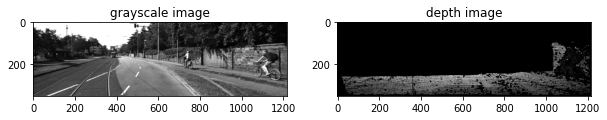

In [32]:
ind = 5
seq = "2011_09_26_drive_0002_sync"
# ind = np.random.randint(0, 553)

color_raw = o3d.io.read_image(os.path.join(path, "image/%s_image_%010d_image_02.png" % (seq, ind)))
depth_raw = o3d.io.read_image(os.path.join(path, "groundtruth_depth/%s_groundtruth_depth_%010d_image_02.png" % (seq, ind)))
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw, depth_raw)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('grayscale image')
plt.imshow(rgbd_image.color, cmap="gray")
plt.subplot(1, 2, 2)
plt.title('depth image')
plt.imshow(rgbd_image.depth, cmap="gray")
plt.show()

#### Intrinsics (camera matrix)

In [43]:
w, h = np.asarray(rgbd_image.color).shape

K = np.loadtxt(os.path.join(path, "intrinsics/%s_image_%010d_image_02.txt" % (seq, ind))).reshape(3, 3)
intrinsics = o3d.camera.PinholeCameraIntrinsic(width=w, height=h,
                                               fx=K[0, 0], fy=K[1, 1], cx=K[0, 2], cy=K[1, 2])

In [44]:
# Usually has shape:
# array([[fx,   0., cx],
#       [  0. , fy, cy],
#       [  0. , 0., 1.]]
# Reference:
# (1) TDV slides: http://cmp.felk.cvut.cz/cmp/courses/TDV/2021W/lectures/tdv-2021-02.pdf
# (2) TDV lecture video (around 38:30): http://cmp.felk.cvut.cz/cmp/courses/TDV/2021W/lectures/tdv-2021-02.mp4

K

array([[721.5377,   0.    , 596.5593],
       [  0.    , 721.5377, 149.854 ],
       [  0.    ,   0.    ,   1.    ]])

#### Point cloud

In [ ]:
pts = np.load(path+f"point_clouds/{ind}.npy")

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pts)
o3d.visualization.draw_geometries([pcd])

#### Create point cloud from RGBD image

In [47]:
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, intrinsics)

# Flip it, otherwise the pointcloud will be upside down
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

o3d.visualization.draw_geometries([pcd])
print(pcd)

geometry::PointCloud with 46813 points.


In [49]:
np.asarray(apcd.points

std::vector<Eigen::Vector3d> with 46813 elements.
Use numpy.asarray() to access data.

#### Dataset

In [ ]:
path

In [ ]:
from gradslam import RGBDImages
from gradslam.datasets import ICL
from torch.utils.data import DataLoader

N = 100

dataset = ICL('../ros_ws/src/gradslam_ros/data/explorer_x1_rgbd_traj/', seqlen=N, height=h, width=w)
loader = DataLoader(dataset=dataset, batch_size=1)
colors, depths, intrinsics, poses, *_ = next(iter(loader))

In [ ]:
poses.shape  # [batch_size, num_poses, 4, 4] - sequence of T = [R|t] matrices, T.shape = (4,4)